## Summary

----

## Imports

In [1]:
import math
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import torch
from kmbio import PDB
from kmtools import structure_tools
from scipy import stats

/home/strokach/env/lib/python3.7/site-packages/Bio/KDTree/__init__.py:27: BiopythonDeprecationWarning: Bio.KDTree has been deprecated, and we intend to remove it in a future release of Biopython. Please use Bio.PDB.kdtrees instead, which is functionally very similar.
  BiopythonDeprecationWarning,


In [2]:
pd.set_option("max_columns", 1000)

In [3]:
%matplotlib inline

## Parameters

In [4]:
NOTEBOOK_NAME = "07_protein_analysis_figures"
NOTEBOOK_PATH = Path(NOTEBOOK_NAME)
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_PATH

PosixPath('07_protein_analysis_figures')

In [5]:
METHOD = "logproba.scan"

MUTATION_METHOD = METHOD
STABILITY_METHOD = METHOD

## Functions

In [6]:
def add_diff(df, colname):
    if f"{colname}_wt" not in df:
        before_ = len(df)
        ext = ".pdb" if not df.iloc[0]["name"].endswith(".pdb") else ""
        row_is_wt = (df["name"] + ext) == df["my_wt"]
        assert set(df[row_is_wt]["my_wt"]) == set(df["my_wt"])
        df2 = df[row_is_wt][["my_wt", colname]].rename(columns={colname: f"{colname}_wt"})
        df = df.merge(df2, on="my_wt")
        assert before_ == len(df), (before_, len(df))
    df[f"{colname}_change"] = df[f"{colname}"] - df[f"{colname}_wt"]
    return df

In [7]:
def get_conf_interval(r, num):
    stderr = 1.0 / math.sqrt(num - 3)
    delta = 1.96 * stderr
    lower = math.tanh(math.atanh(r) - delta)
    upper = math.tanh(math.atanh(r) + delta)
    return r - lower, upper - r 

In [8]:
def get_aa_sequence(structure_file):
    structure = PDB.load(structure_file)
    model_id = next(structure.models).id
    chain_id = next(structure.chains).id
    aa_sequence = structure_tools.extract_aa_sequence(structure, model_id, chain_id)
    return aa_sequence

## Load data

### Rosetta scores - Protherm

In [9]:
get_aa_sequence(
    "/home/kimlab1/strokach/datapkg/adjacency-net-v2/notebooks/protherm_dataset/structures/pdb107l.entA_0--G44S-wt.pdb"
)

'MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKGELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYK'

In [10]:
!ls /home/kimlab1/strokach/datapkg/adjacency-net-v2/notebooks/protherm_dataset/structures/ | head -n 2

pdb107l.entA_0--G44S-wt.pdb
pdb160l.entA_0--A120M-wt.pdb
ls: write error: Broken pipe


In [11]:
STRUCTURES_PATH = Path("/home/kimlab1/strokach/datapkg/adjacency-net-v2/notebooks/protherm_dataset/structures/").resolve(strict=True)
STRUCTURES_PATH

PosixPath('/home/kimlab1/database_data/datapkg/adjacency-net-v2/notebooks/protherm_dataset/structures')

In [12]:
protherm_design_rue = pd.read_csv(NOTEBOOK_PATH.joinpath("protherm_design_wt_RUE.csv"), index_col=0)

#### Average out energies of wild-type structures

In [13]:
protherm_design_rue["filename_prefix"] = protherm_design_rue["filename"].str.split("-").str[0]

In [14]:
filename_prefix_to_reu_wt = {}
for filename_prefix, gp in protherm_design_rue.groupby("filename_prefix"):
    filename_prefix_to_reu_wt[filename_prefix] = gp["RUE_wt"].mean()
print(len(filename_prefix_to_reu_wt))

179


In [15]:
protherm_design_rue["RUE_wt_2"] = protherm_design_rue["filename_prefix"].map(filename_prefix_to_reu_wt)

In [16]:
protherm_design_rue["rosetta_reu_change"] = protherm_design_rue["RUE_mut"] - protherm_design_rue["RUE_wt_2"]

In [17]:
stats.spearmanr(protherm_design_rue["rosetta_reu_change"], protherm_design_rue["ddg_exp"])

SpearmanrResult(correlation=-0.008007305189965822, pvalue=0.6372197700858309)

#### Normalize by sequence length

In [18]:
try:
    protherm_design_rue["sequence_length"] = torch.load(NOTEBOOK_PATH.joinpath("protherm-sequence-lengths.torch"))
except FileNotFoundError:
    sequence_lengths = [
        len(get_aa_sequence(STRUCTURES_PATH.joinpath(s))) for s in tqdm(protherm_design_rue["filename"].values)
    ]
    torch.save(sequence_lengths, NOTEBOOK_PATH.joinpath("protherm-sequence-lengths.torch"))
    protherm_design_rue["sequence_length"] = sequence_lengths

In [19]:
protherm_design_rue["rosetta_reu_norm_change"] = protherm_design_rue["rosetta_reu_change"] / protherm_design_rue["sequence_length"]

In [20]:
stats.spearmanr(protherm_design_rue["rosetta_reu_norm_change"], protherm_design_rue["ddg_exp"])

SpearmanrResult(correlation=0.08262914198402263, pvalue=1.0897621694155652e-06)

### GAPF scores

In [21]:
gapf_design_rue = pd.read_csv(NOTEBOOK_PATH.joinpath("GAPF_design_RUE_wt.csv"))

In [22]:
display(gapf_design_rue.head(2))

,my_wt,pos,wt_aa,mut,sequence,RUE,RUE_wt
0,EEHEE_rd3_0037.pdb,19,A,D,TTIKVNGQEYTVPLSPEQDAKAAKKRWPDYEVQIHGNTVKVTR,-67.630,-118.76
1,EEHEE_rd3_0037.pdb,19,A,E,TTIKVNGQEYTVPLSPEQEAKAAKKRWPDYEVQIHGNTVKVTR,-13.011,-118.76


### Protherm

In [23]:
protherm_wresults_df = torch.load(NOTEBOOK_PATH.parent.joinpath("protein_analysis", "protherm_wresults.torch"))

In [24]:
display(protherm_wresults_df.head(2))

,filename_wt,chain_id,mutation,cartesian_ddg_beta_nov15_cart_1,ddg_exp,cartesian_ddg_beta_nov16_cart_1,cartesian_ddg_score12_cart_1,cartesian_ddg_talaris2013_cart_1,cartesian_ddg_talaris2014_cart_1,ddg_monomer_soft_rep_design_1,local_filename_wt,structure_id,model_id,qseq,residue_idx_1_corrected,residue_idx_2_corrected,distances,mutation_matches_sequence,qseq_mutation,wt_wt,wt_mut,wt_sm_wt,wt_sm_mut,wt_sm_log_wt,wt_sm_log_mut,mut_wt,mut_mut,mut_sm_wt,mut_sm_mut,mut_sm_log_wt,mut_sm_log_mut,blank_wt,blank_mut,blank_sm_wt,blank_sm_mut,blank_sm_log_wt,blank_sm_log_mut,scan_wt,scan_mut,scan_sm_wt,scan_sm_mut,scan_sm_log_wt,scan_sm_log_mut,incremental_wt,incremental_mut,incremental_sm_wt,incremental_sm_mut,incremental_sm_log_wt,incremental_sm_log_mut,blank_change,blank_sm_change,wt_mut_change,wt_mut_sm_change,scan_change,scan_sm_change,scan_sm_log_change,incremental_change,incremental_sm_change,incremental_sm_log_change
0,/home/kimlab2/database_data/biological-data-wa...,A,G44S,-1.808667,-0.53,-0.701,0.088,-0.289667,-0.633667,-2.384,/home/kimlab1/database_data/datapkg/adjacency-...,107l,0,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKGEL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 66, 70, 91...","[1.3463744749991646, 4.7287436401778065, 6.389...",True,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,24.131248,7.463029,1.000000,5.768777e-08,0.000000,-16.668221,-0.822239,18.555481,3.840270e-09,0.999997,-19.377724,-0.000003,-0.785366,0.187889,0.013420,0.035516,-4.311016,-3.337761,3.701211,3.713295,0.343849,0.344718,-1.652878,-1.642744,3.488405,3.494410,0.331307,0.331441,-1.689137,-1.683219,0.973255,0.022096,-5.575768,-0.000003,0.012084,0.000869,0.010134,0.006004,0.000135,0.005919
1,/home/kimlab2/database_data/biological-data-wa...,A,A120M,2.617667,-0.20,0.354,0.560,-0.069000,-0.188000,2.472,/home/kimlab1/database_data/datapkg/adjacency-...,160l,0,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 66, 70, 91, 92...","[1.345760255620924, 4.727237880524551, 6.42311...",True,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,18.279926,-7.932950,0.999999,4.129451e-12,-0.000001,-26.212877,-5.231137,20.824055,4.834716e-12,0.999992,-26.055199,-0.000008,2.087064,-0.255827,0.264194,0.025376,-1.331073,-3.673964,3.762726,3.734712,0.334620,0.332865,-1.675424,-1.687917,3.623382,3.601132,0.329045,0.327471,-1.718992,-1.734681,-2.342890,-0.238818,2.544128,-0.000006,-0.028014,-0.001755,-0.012493,-0.022250,-0.001574,-0.015689


In [25]:
assert (protherm_wresults_df["mutation"] == protherm_design_rue["mutation"]).all()

In [26]:
protherm_wresults_df["rosetta_reu_change"] = protherm_design_rue["rosetta_reu_change"]
protherm_wresults_df["rosetta_reu_norm_change"] = protherm_design_rue["rosetta_reu_norm_change"]

### GAPF - Mutations

In [27]:
stability_scores_for_mutations = torch.load(
    NOTEBOOK_PATH.parent.joinpath(
        "06_global_analysis_of_protein_folding", f"stability_scores_for_mutations.{METHOD}.torch"
    )
)

In [28]:
stability_scores_for_mutations["ssm2"]

,name,sequence,my_wt,pos,mut,wt_aa,ec50_t,delta_ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,delta_pred_vs_wt_t,ec50_rise_t,stabilityscore_t,ec50_c,delta_ec50_c,ec50_95ci_lbound_c,ec50_95ci_ubound_c,ec50_95ci_c,ec50_pred_c,delta_pred_vs_wt_c,ec50_rise_c,stabilityscore_c,ec50_rise_c_adj,stabilityscore_c_adj,consensus_ec50_rise,consensus_stability_score,library_name,network_score
0,EEHEE_rd3_0037.pdb,TTIKVNGQEYTVPLSPEQAAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,0,na,wt,4.67,0.00,4.7,4.7,0.0,-1.02,0.00,5.69,1.71,3.33,0.00,3.3,3.3,0.0,0.51,0.00,2.83,0.85,2.83,0.85,2.83,0.85,ssm2,-80.553299
1,EEHEE_rd3_0037.pdb_A19D,TTIKVNGQEYTVPLSPEQDAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,19,D,A,-0.40,-5.07,-0.5,-0.3,0.2,-0.87,0.15,0.47,0.14,1.81,-1.52,1.7,1.9,0.2,0.81,0.30,1.00,0.30,1.00,0.30,0.99,0.30,ssm2,-88.784714
2,EEHEE_rd3_0037.pdb_A19E,TTIKVNGQEYTVPLSPEQEAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,19,E,A,-0.32,-4.99,-0.4,-0.2,0.2,-0.94,0.08,0.62,0.19,1.49,-1.85,1.4,1.6,0.2,0.73,0.22,0.76,0.23,0.76,0.23,0.76,0.23,ssm2,-87.736244
3,EEHEE_rd3_0037.pdb_A19F,TTIKVNGQEYTVPLSPEQFAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,19,F,A,1.72,-2.95,1.7,1.8,0.1,-1.34,-0.32,3.06,0.92,1.88,-1.45,1.8,2.0,0.2,0.13,-0.37,1.75,0.53,1.75,0.53,1.83,0.55,ssm2,-88.539017
4,EEHEE_rd3_0037.pdb_A19G,TTIKVNGQEYTVPLSPEQGAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,19,G,A,1.85,-2.82,1.8,2.2,0.4,-0.98,0.04,2.83,0.85,2.46,-0.87,2.4,2.6,0.2,0.62,0.12,1.84,0.55,1.84,0.55,1.77,0.53,ssm2,-84.611320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12846,villin_W23R,GSSGSLSDEDFKAVFGMTRSAFANLPLRKQQNLKKEKGLFGSS,villin,23,R,W,1.69,-2.36,1.6,1.8,0.2,-0.68,-0.61,2.37,0.71,1.12,-1.38,0.9,1.6,0.7,-1.20,-0.11,2.31,0.70,2.31,0.70,2.57,0.77,ssm2,-88.528976
12847,villin_W23S,GSSGSLSDEDFKAVFGMTRSAFANLPLSKQQNLKKEKGLFGSS,villin,23,S,W,2.65,-1.40,2.6,2.7,0.1,0.10,0.17,2.55,0.77,1.69,-0.81,1.5,1.8,0.3,-0.94,0.15,2.63,0.79,2.63,0.79,2.72,0.82,ssm2,-87.304192
12848,villin_W23T,GSSGSLSDEDFKAVFGMTRSAFANLPLTKQQNLKKEKGLFGSS,villin,23,T,W,2.43,-1.62,2.2,2.6,0.4,0.11,0.18,2.32,0.70,1.78,-0.72,1.6,1.9,0.3,-0.89,0.20,2.67,0.80,2.67,0.80,2.63,0.79,ssm2,-87.545433
12849,villin_W23V,GSSGSLSDEDFKAVFGMTRSAFANLPLVKQQNLKKEKGLFGSS,villin,23,V,W,2.05,-2.00,1.9,2.2,0.3,-0.14,-0.07,2.20,0.66,1.62,-0.88,1.5,1.8,0.3,-1.00,0.09,2.62,0.79,2.62,0.79,2.57,0.77,ssm2,-87.529152


#### Format `ssm2`

In [29]:
stability_scores_for_mutations["ssm2"]["consensus_stability_score2"] = (
    stability_scores_for_mutations["ssm2"]["stabilityscore_t"]
    + stability_scores_for_mutations["ssm2"]["stabilityscore_c"]
) / 2

In [30]:
for column in [
    "network_score",
    "stabilityscore_t",
    "stabilityscore_c",
    "consensus_stability_score",
    "consensus_stability_score2",
]:
    stability_scores_for_mutations["ssm2"] = add_diff(stability_scores_for_mutations["ssm2"], column)

In [31]:
display(stability_scores_for_mutations["ssm2"].head(2))

,name,sequence,my_wt,pos,mut,wt_aa,ec50_t,delta_ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,delta_pred_vs_wt_t,ec50_rise_t,stabilityscore_t,ec50_c,delta_ec50_c,ec50_95ci_lbound_c,ec50_95ci_ubound_c,ec50_95ci_c,ec50_pred_c,delta_pred_vs_wt_c,ec50_rise_c,stabilityscore_c,ec50_rise_c_adj,stabilityscore_c_adj,consensus_ec50_rise,consensus_stability_score,library_name,network_score,consensus_stability_score2,network_score_wt,network_score_change,stabilityscore_t_wt,stabilityscore_t_change,stabilityscore_c_wt,stabilityscore_c_change,consensus_stability_score_wt,consensus_stability_score_change,consensus_stability_score2_wt,consensus_stability_score2_change
0,EEHEE_rd3_0037.pdb,TTIKVNGQEYTVPLSPEQAAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,0,na,wt,4.67,0.00,4.7,4.7,0.0,-1.02,0.00,5.69,1.71,3.33,0.00,3.3,3.3,0.0,0.51,0.0,2.83,0.85,2.83,0.85,2.83,0.85,ssm2,-80.553299,1.28,-80.553299,0.000000,1.71,0.00,0.85,0.00,0.85,0.00,1.28,0.00
1,EEHEE_rd3_0037.pdb_A19D,TTIKVNGQEYTVPLSPEQDAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,19,D,A,-0.40,-5.07,-0.5,-0.3,0.2,-0.87,0.15,0.47,0.14,1.81,-1.52,1.7,1.9,0.2,0.81,0.3,1.00,0.30,1.00,0.30,0.99,0.30,ssm2,-88.784714,0.22,-80.553299,-8.231415,1.71,-1.57,0.85,-0.55,0.85,-0.55,1.28,-1.06


In [32]:
if "rosetta_reu_change" not in stability_scores_for_mutations["ssm2"]:
    stability_scores_for_mutations["ssm2"] = stability_scores_for_mutations["ssm2"].merge(
        gapf_design_rue, on=["my_wt", "pos", "wt_aa", "mut", "sequence"], how="left", validate="1:1"
    )
    stability_scores_for_mutations["ssm2"]["rosetta_reu_change"] = (
        stability_scores_for_mutations["ssm2"]["RUE"] - stability_scores_for_mutations["ssm2"]["RUE_wt"]
    )

In [33]:
missing_reu_df = stability_scores_for_mutations["ssm2"][
    stability_scores_for_mutations["ssm2"]["rosetta_reu_change"].isnull()
]

In [34]:
len(missing_reu_df)

2951

In [35]:
(missing_reu_df["pos"] != 0).sum()

2934

In [36]:
(missing_reu_df["mut"] != "na").sum()

2934

#### Format `fig1`

In [37]:
stability_scores_for_mutations["fig1"] = stability_scores_for_mutations["fig1"].rename(
    columns={"deltaGunf thermal": "dg_thermal", "deltaGunf chemical": "dg_chemical"}
)

stability_scores_for_mutations["fig1"]["consensus_stability_score"] = (
    stability_scores_for_mutations["fig1"]["stabilityscore_t"]
    + stability_scores_for_mutations["fig1"]["stabilityscore_c"]
) / 2

stability_scores_for_mutations["fig1"]["consensus_dg"] = (
    stability_scores_for_mutations["fig1"]["dg_thermal"] + stability_scores_for_mutations["fig1"]["dg_chemical"]
) / 2

In [38]:
for column in [
    "network_score",
    "stabilityscore_t",
    "stabilityscore_c",
    "consensus_stability_score",
    "dg_thermal",
    "dg_chemical",
    "consensus_dg",
    "Tm",
]:
    stability_scores_for_mutations["fig1"] = add_diff(stability_scores_for_mutations["fig1"], column)

### GAPF - Stability

In [39]:
stability_scores_for_designs = torch.load(
    NOTEBOOK_PATH.parent.joinpath(
        "06_global_analysis_of_protein_folding", f"stability_scores_for_selections.{METHOD}.torch"
    )
)

## Figures

### Protherm

In [40]:
protherm_wresults_df.head(2)

,filename_wt,chain_id,mutation,cartesian_ddg_beta_nov15_cart_1,ddg_exp,cartesian_ddg_beta_nov16_cart_1,cartesian_ddg_score12_cart_1,cartesian_ddg_talaris2013_cart_1,cartesian_ddg_talaris2014_cart_1,ddg_monomer_soft_rep_design_1,local_filename_wt,structure_id,model_id,qseq,residue_idx_1_corrected,residue_idx_2_corrected,distances,mutation_matches_sequence,qseq_mutation,wt_wt,wt_mut,wt_sm_wt,wt_sm_mut,wt_sm_log_wt,wt_sm_log_mut,mut_wt,mut_mut,mut_sm_wt,mut_sm_mut,mut_sm_log_wt,mut_sm_log_mut,blank_wt,blank_mut,blank_sm_wt,blank_sm_mut,blank_sm_log_wt,blank_sm_log_mut,scan_wt,scan_mut,scan_sm_wt,scan_sm_mut,scan_sm_log_wt,scan_sm_log_mut,incremental_wt,incremental_mut,incremental_sm_wt,incremental_sm_mut,incremental_sm_log_wt,incremental_sm_log_mut,blank_change,blank_sm_change,wt_mut_change,wt_mut_sm_change,scan_change,scan_sm_change,scan_sm_log_change,incremental_change,incremental_sm_change,incremental_sm_log_change,rosetta_reu_change,rosetta_reu_norm_change
0,/home/kimlab2/database_data/biological-data-wa...,A,G44S,-1.808667,-0.53,-0.701,0.088,-0.289667,-0.633667,-2.384,/home/kimlab1/database_data/datapkg/adjacency-...,107l,0,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKGEL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 66, 70, 91...","[1.3463744749991646, 4.7287436401778065, 6.389...",True,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,24.131248,7.463029,1.000000,5.768777e-08,0.000000,-16.668221,-0.822239,18.555481,3.840270e-09,0.999997,-19.377724,-0.000003,-0.785366,0.187889,0.013420,0.035516,-4.311016,-3.337761,3.701211,3.713295,0.343849,0.344718,-1.652878,-1.642744,3.488405,3.494410,0.331307,0.331441,-1.689137,-1.683219,0.973255,0.022096,-5.575768,-0.000003,0.012084,0.000869,0.010134,0.006004,0.000135,0.005919,177.323,1.094586
1,/home/kimlab2/database_data/biological-data-wa...,A,A120M,2.617667,-0.20,0.354,0.560,-0.069000,-0.188000,2.472,/home/kimlab1/database_data/datapkg/adjacency-...,160l,0,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 66, 70, 91, 92...","[1.345760255620924, 4.727237880524551, 6.42311...",True,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,18.279926,-7.932950,0.999999,4.129451e-12,-0.000001,-26.212877,-5.231137,20.824055,4.834716e-12,0.999992,-26.055199,-0.000008,2.087064,-0.255827,0.264194,0.025376,-1.331073,-3.673964,3.762726,3.734712,0.334620,0.332865,-1.675424,-1.687917,3.623382,3.601132,0.329045,0.327471,-1.718992,-1.734681,-2.342890,-0.238818,2.544128,-0.000006,-0.028014,-0.001755,-0.012493,-0.022250,-0.001574,-0.015689,215.667,1.331278


In [41]:
assert (protherm_wresults_df["rosetta_reu_change"].notnull().all())

In [42]:
y_col = "ddg_exp"

correlations = []
for x_col in [
    "cartesian_ddg_beta_nov15_cart_1",
    "cartesian_ddg_beta_nov16_cart_1",
    "cartesian_ddg_score12_cart_1",
    "cartesian_ddg_talaris2013_cart_1",
    "cartesian_ddg_talaris2014_cart_1",
    "ddg_monomer_soft_rep_design_1",
    "scan_sm_log_change",
    "rosetta_reu_change",
    "rosetta_reu_norm_change",
]:
    x_data = protherm_wresults_df[x_col]
    if x_col == "scan_sm_log_change":
        x_data = -x_data
    corr = stats.spearmanr(x_data, protherm_wresults_df[y_col])
    corr_conf = get_conf_interval(corr[0], len(protherm_wresults_df))
    correlations.append(
        {
            "feature": x_col,
            "corr": corr[0],
            "pvalue": corr[1],
            "corr_lower_bound": corr_conf[0],
            "corr_upper_bound": corr_conf[1],
        }
    )
protherm_correlations_df = pd.DataFrame(correlations, columns=correlations[0].keys())

In [43]:
protherm_correlations_df = pd.concat([
    protherm_correlations_df,
    pd.DataFrame([("design_beta_nov", 0.51, 0.0, 0.02, 0.02)], columns=protherm_correlations_df.columns)
], ignore_index=True)

In [44]:
protherm_correlations_df

,feature,corr,pvalue,corr_lower_bound,corr_upper_bound
0,cartesian_ddg_beta_nov15_cart_1,0.550295,4.655341e-274,0.023628,0.022778
1,cartesian_ddg_beta_nov16_cart_1,0.591317,0.000000e+00,0.022071,0.021220
2,cartesian_ddg_score12_cart_1,0.512658,5.364499e-232,0.024952,0.024115
3,cartesian_ddg_talaris2013_cart_1,0.540721,7.546098e-263,0.023974,0.023127
4,cartesian_ddg_talaris2014_cart_1,0.545413,2.685894e-268,0.023805,0.022957
5,ddg_monomer_soft_rep_design_1,0.316684,1.052233e-81,0.030252,0.029622
6,scan_sm_log_change,0.443801,1.783294e-167,0.027118,0.026329
7,rosetta_reu_change,-0.008009,6.371405e-01,0.033259,0.033277
8,rosetta_reu_norm_change,0.082635,1.087827e-06,0.033134,0.032952
9,design_beta_nov,0.510000,0.000000e+00,0.020000,0.020000


In [45]:
feature_to_name = {
    "rosetta_reu_change": "Rosetta (fixbb)",
    "rosetta_reu_norm_change": "Rosetta (fixbb)",
    "cartesian_ddg_beta_nov15_cart_1": "Rosetta (cartesian_ddg)",
    "cartesian_ddg_beta_nov16_cart_1": "Rosetta (cartesian_ddg)",
    "cartesian_ddg_score12_cart_1": "Rosetta (cartesian_ddg)",
    "cartesian_ddg_talaris2013_cart_1": "Rosetta (cartesian_ddg)",
    "cartesian_ddg_talaris2014_cart_1": "Rosetta (cartesian_ddg)",
    "ddg_monomer_soft_rep_design_1": "Rosetta (ddg_monomer)",
    "scan_sm_log_change": "ProteinSolver",
}

In [46]:
protherm_correlations_df["label"] = protherm_correlations_df["feature"].map(feature_to_name)
protherm_correlations_df["name"] = "Protherm"

In [47]:
protherm_correlations_df

,feature,corr,pvalue,corr_lower_bound,corr_upper_bound,label,name
0,cartesian_ddg_beta_nov15_cart_1,0.550295,4.655341e-274,0.023628,0.022778,Rosetta (cartesian_ddg),Protherm
1,cartesian_ddg_beta_nov16_cart_1,0.591317,0.000000e+00,0.022071,0.021220,Rosetta (cartesian_ddg),Protherm
2,cartesian_ddg_score12_cart_1,0.512658,5.364499e-232,0.024952,0.024115,Rosetta (cartesian_ddg),Protherm
3,cartesian_ddg_talaris2013_cart_1,0.540721,7.546098e-263,0.023974,0.023127,Rosetta (cartesian_ddg),Protherm
4,cartesian_ddg_talaris2014_cart_1,0.545413,2.685894e-268,0.023805,0.022957,Rosetta (cartesian_ddg),Protherm
5,ddg_monomer_soft_rep_design_1,0.316684,1.052233e-81,0.030252,0.029622,Rosetta (ddg_monomer),Protherm
6,scan_sm_log_change,0.443801,1.783294e-167,0.027118,0.026329,ProteinSolver,Protherm
7,rosetta_reu_change,-0.008009,6.371405e-01,0.033259,0.033277,Rosetta (fixbb),Protherm
8,rosetta_reu_norm_change,0.082635,1.087827e-06,0.033134,0.032952,Rosetta (fixbb),Protherm
9,design_beta_nov,0.510000,0.000000e+00,0.020000,0.020000,NaN,Protherm


ProteinSolver -0.225 [-0.375 -0.225 -0.075  0.075  0.225  0.375]
[-0.225] [0.44380118]
Rosetta (fixbb) -0.07500000000000001 [-0.375 -0.225 -0.075  0.075  0.225  0.375]
[-0.075] [0.08263507]
Rosetta (ddg_monomer) 0.07499999999999996 [-0.375 -0.225 -0.075  0.075  0.225  0.375]
[0.075] [0.31668374]
Rosetta (cartesian_ddg) 0.22499999999999998 [-0.375 -0.225 -0.075  0.075  0.225  0.375]
[0.225] [0.59131662]


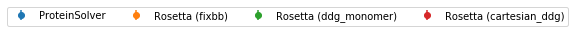

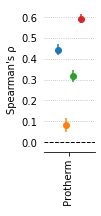

In [48]:
features_to_compare = [
    "scan_sm_log_change",
    "rosetta_reu_norm_change",
    "ddg_monomer_soft_rep_design_1",
    "cartesian_ddg_beta_nov16_cart_1",
]

figl, axl = plt.subplots(figsize=(8, 0.35))

fig, ax = plt.subplots(figsize=(1.3, 3))

gp = protherm_correlations_df.set_index("feature").loc[features_to_compare].reset_index()

width = 0.75  # the width of the bars

labels = gp["label"].unique()
offsets = np.linspace(-width / 2, width / 2, len(labels) + 2)
for j, label in enumerate(labels):
    print(label, offsets[j + 1], offsets)
    gp_subset = gp[gp["label"] == label]
    x = np.arange(len(gp_subset))  # the label locations
    x_subset = x + offsets[j + 1]
    print(x_subset, gp_subset["corr"].values)
    rects1 = ax.errorbar(
        x_subset,
        gp_subset["corr"].values,
        fmt="o",
        #         width,
        yerr=gp_subset[["corr_lower_bound", "corr_upper_bound"]].values.T,
        label=label,
    )

ax.set_ylim(-0.05, 0.65)
ax.set_ylabel("Spearman's ρ")

ax.set_xticks(x)
ax.set_xticklabels([f"{'Protherm':>9s}"], rotation="vertical")
# ax.set_xlabel(group)
ax.set_xlim(x[0] - 0.5, x[-1] + 0.5)
ax.hlines(0, x[0] - 0.5, x[-1] + 0.5, linestyles="--", linewidth=1)

for tic in ax.yaxis.get_major_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.grid(axis="y", linestyle=":")

axl.legend(*ax.get_legend_handles_labels(), ncol=4, bbox_to_anchor=(1.133, 1.25))
axl.axis("off")

fig.subplots_adjust(left=0.41, bottom=0.325, top=1, right=0.95)
fig.savefig(NOTEBOOK_PATH.joinpath("protherm-correlations.pdf"))
fig.savefig(NOTEBOOK_PATH.joinpath("protherm-correlations.svg"))
fig.savefig(NOTEBOOK_PATH.joinpath("protherm-correlations.png"), dpi=300)

figl.savefig(NOTEBOOK_PATH.joinpath("legend.pdf"))
figl.savefig(NOTEBOOK_PATH.joinpath("legend.svg"))
figl.savefig(NOTEBOOK_PATH.joinpath("legend.png"), dpi=300)

In [49]:
!realpath {NOTEBOOK_PATH}/protherm-correlations.png

/home/kimlab1/strokach/workspace/proteinsolver/notebooks/07_protein_analysis_figures/protherm-correlations.png


### GAPF - Mutations

In [50]:
stability_scores_for_mutations["ssm2"]

,name,sequence,my_wt,pos,mut,wt_aa,ec50_t,delta_ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,delta_pred_vs_wt_t,ec50_rise_t,stabilityscore_t,ec50_c,delta_ec50_c,ec50_95ci_lbound_c,ec50_95ci_ubound_c,ec50_95ci_c,ec50_pred_c,delta_pred_vs_wt_c,ec50_rise_c,stabilityscore_c,ec50_rise_c_adj,stabilityscore_c_adj,consensus_ec50_rise,consensus_stability_score,library_name,network_score,consensus_stability_score2,network_score_wt,network_score_change,stabilityscore_t_wt,stabilityscore_t_change,stabilityscore_c_wt,stabilityscore_c_change,consensus_stability_score_wt,consensus_stability_score_change,consensus_stability_score2_wt,consensus_stability_score2_change,RUE,RUE_wt,rosetta_reu_change
0,EEHEE_rd3_0037.pdb,TTIKVNGQEYTVPLSPEQAAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,0,na,wt,4.67,0.00,4.7,4.7,0.0,-1.02,0.00,5.69,1.71,3.33,0.00,3.3,3.3,0.0,0.51,0.00,2.83,0.85,2.83,0.85,2.83,0.85,ssm2,-80.553299,1.280,-80.553299,0.000000,1.71,0.00,0.85,0.00,0.85,0.00,1.28,0.000,NaN,NaN,NaN
1,EEHEE_rd3_0037.pdb_A19D,TTIKVNGQEYTVPLSPEQDAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,19,D,A,-0.40,-5.07,-0.5,-0.3,0.2,-0.87,0.15,0.47,0.14,1.81,-1.52,1.7,1.9,0.2,0.81,0.30,1.00,0.30,1.00,0.30,0.99,0.30,ssm2,-88.784714,0.220,-80.553299,-8.231415,1.71,-1.57,0.85,-0.55,0.85,-0.55,1.28,-1.060,-67.630,-118.760,51.130
2,EEHEE_rd3_0037.pdb_A19E,TTIKVNGQEYTVPLSPEQEAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,19,E,A,-0.32,-4.99,-0.4,-0.2,0.2,-0.94,0.08,0.62,0.19,1.49,-1.85,1.4,1.6,0.2,0.73,0.22,0.76,0.23,0.76,0.23,0.76,0.23,ssm2,-87.736244,0.210,-80.553299,-7.182945,1.71,-1.52,0.85,-0.62,0.85,-0.62,1.28,-1.070,-13.011,-118.760,105.749
3,EEHEE_rd3_0037.pdb_A19F,TTIKVNGQEYTVPLSPEQFAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,19,F,A,1.72,-2.95,1.7,1.8,0.1,-1.34,-0.32,3.06,0.92,1.88,-1.45,1.8,2.0,0.2,0.13,-0.37,1.75,0.53,1.75,0.53,1.83,0.55,ssm2,-88.539017,0.725,-80.553299,-7.985718,1.71,-0.79,0.85,-0.32,0.85,-0.30,1.28,-0.555,14.017,-118.760,132.777
4,EEHEE_rd3_0037.pdb_A19G,TTIKVNGQEYTVPLSPEQGAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,19,G,A,1.85,-2.82,1.8,2.2,0.4,-0.98,0.04,2.83,0.85,2.46,-0.87,2.4,2.6,0.2,0.62,0.12,1.84,0.55,1.84,0.55,1.77,0.53,ssm2,-84.611320,0.700,-80.553299,-4.058022,1.71,-0.86,0.85,-0.30,0.85,-0.32,1.28,-0.580,-94.158,-118.760,24.602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12846,villin_W23R,GSSGSLSDEDFKAVFGMTRSAFANLPLRKQQNLKKEKGLFGSS,villin,23,R,W,1.69,-2.36,1.6,1.8,0.2,-0.68,-0.61,2.37,0.71,1.12,-1.38,0.9,1.6,0.7,-1.20,-0.11,2.31,0.70,2.31,0.70,2.57,0.77,ssm2,-88.528976,0.705,-88.646500,0.117523,1.24,-0.53,1.08,-0.38,1.08,-0.31,1.16,-0.455,40.370,-60.364,100.734
12847,villin_W23S,GSSGSLSDEDFKAVFGMTRSAFANLPLSKQQNLKKEKGLFGSS,villin,23,S,W,2.65,-1.40,2.6,2.7,0.1,0.10,0.17,2.55,0.77,1.69,-0.81,1.5,1.8,0.3,-0.94,0.15,2.63,0.79,2.63,0.79,2.72,0.82,ssm2,-87.304192,0.780,-88.646500,1.342308,1.24,-0.47,1.08,-0.29,1.08,-0.26,1.16,-0.380,41.506,-60.364,101.870
12848,villin_W23T,GSSGSLSDEDFKAVFGMTRSAFANLPLTKQQNLKKEKGLFGSS,villin,23,T,W,2.43,-1.62,2.2,2.6,0.4,0.11,0.18,2.32,0.70,1.78,-0.72,1.6,1.9,0.3,-0.89,0.20,2.67,0.80,2.67,0.80,2.63,0.79,ssm2,-87.545433,0.750,-88.646500,1.101067,1.24,-0.54,1.08,-0.28,1.08,-0.29,1.16,-0.410,39.683,-60.364,100.047
12849,villin_W23V,GSSGSLSDEDFKAVFGMTRSAFANLPLVKQQNLKKEKGLFGSS,villin,23,V,W,2.05,-2.00,1.9,2.2,0.3,-0.14,-0.07,2.20,0.66,1.62,-0.88,1.5,1.8,0.3,-1.00,0.09,2.62,0.79,2.62,0.79,2.57,0.77,ssm2,-87.529152,0.725,-88.646500,1.117348,1.24,-0.58,1.08,-0.29,1.08,-0.31,1.16,-0.435,42.727,-60.364,103.091


In [51]:
x_cols = ["network_score_change", "rosetta_reu_change"]
y_col = "consensus_stability_score_change"
library = "ssm2"

correlations = []

for my_wt, gp in stability_scores_for_mutations[library].groupby("my_wt"):
    x = gp[x_cols + ["consensus_stability_score_change"]].dropna()
    print(len(x))
    if x.empty:
        print(f"Skipping {my_wt}!")
        continue
    for x_col in x_cols:
        x_data = x[x_col]
        if x_col != "network_score_change":
            x_data = -x_data
        corr = stats.spearmanr(x_data, x[y_col])
        corr_conf = get_conf_interval(corr[0], len(x))
        correlations.append(
            {
                "my_wt": my_wt,
                "x_col": x_col,
                "corr": corr[0],
                "pvalue": corr[1],
                "corr_lower_bound": corr_conf[0],
                "corr_upper_bound": corr_conf[1],
            }
        )
correlations_df = pd.DataFrame(correlations, columns=correlations[0].keys())

774
774
774
774
0
Skipping EHEE_0882.pdb!
0
Skipping EHEE_rd2_0005.pdb!
0
Skipping EHEE_rd3_0015.pdb!
774
774
774
774
0
Skipping HHH_0142.pdb!
774
774
702
828
630


In [52]:
correlations_df

,my_wt,x_col,corr,pvalue,corr_lower_bound,corr_upper_bound
0,EEHEE_rd3_0037.pdb,network_score_change,0.460049,8.467329e-42,0.057417,0.053811
1,EEHEE_rd3_0037.pdb,rosetta_reu_change,0.559170,7.158773e-65,0.050423,0.046600
2,EEHEE_rd3_1498.pdb,network_score_change,0.426276,1.613250e-35,0.059451,0.055984
3,EEHEE_rd3_1498.pdb,rosetta_reu_change,0.308186,1.715332e-18,0.065193,0.062422
4,EEHEE_rd3_1702.pdb,network_score_change,0.115665,1.266285e-03,0.070099,0.068966
5,EEHEE_rd3_1702.pdb,rosetta_reu_change,0.291676,1.207908e-16,0.065828,0.063177
6,EEHEE_rd3_1716.pdb,network_score_change,0.440026,5.444404e-38,0.058644,0.055117
7,EEHEE_rd3_1716.pdb,rosetta_reu_change,0.524562,6.152183e-56,0.053040,0.049259
8,HEEH_rd2_0779.pdb,network_score_change,0.536132,8.259358e-59,0.052186,0.048387
9,HEEH_rd2_0779.pdb,rosetta_reu_change,0.541084,4.502591e-60,0.051815,0.048008


In [53]:
def to_name(s):
    s = s.replace(".pdb", "")
    if "_" in s:
        s1, s2 = s.split("_", 1)
        s2 = s2.replace("_", "-")
        return s1, f"{s2:>9s}"
    else:
        return "Known", f"{s:>9s}"


df = correlations_df.copy()
df["group"], df["name"] = list(zip(*df["my_wt"].apply(to_name).values))
df = df.sort_values("my_wt", ascending=False)

df

,my_wt,x_col,corr,pvalue,corr_lower_bound,corr_upper_bound,group,name
25,villin,rosetta_reu_change,0.170801,1.630638e-05,0.076862,0.074838,Known,villin
24,villin,network_score_change,0.603572,8.754531e-64,0.052115,0.047422,Known,villin
23,hYAP65,rosetta_reu_change,0.195609,1.386447e-08,0.066411,0.064664,Known,hYAP65
22,hYAP65,network_score_change,0.494401,2.982107e-52,0.053273,0.049801,Known,hYAP65
21,Pin1,rosetta_reu_change,0.202497,6.238602e-08,0.072044,0.069917,Known,Pin1
20,Pin1,network_score_change,0.392996,2.404553e-27,0.064444,0.060802,Known,Pin1
19,HHH_rd3_0138.pdb,rosetta_reu_change,0.375683,2.367396e-27,0.062171,0.058964,HHH,rd3-0138
18,HHH_rd3_0138.pdb,network_score_change,0.463645,1.646910e-42,0.057190,0.053571,HHH,rd3-0138
17,HHH_rd2_0134.pdb,rosetta_reu_change,0.323187,2.822284e-20,0.064581,0.061705,HHH,rd2-0134
16,HHH_rd2_0134.pdb,network_score_change,0.288326,2.770641e-16,0.065952,0.063326,HHH,rd2-0134


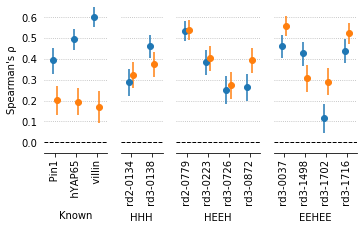

In [54]:
fig, axs = plt.subplots(1, 4, figsize=(5, 3), gridspec_kw={'width_ratios': [3, 2, 4, 4]})

for i, (group, gp) in enumerate(sorted(df.groupby("group"), key=lambda t: t[0], reverse=True)):
    ax = axs[i]

    gp = gp.sort_values("name")
    gp_proteinsolver = gp[gp["x_col"] == "network_score_change"]
    gp_rosetta = gp[gp["x_col"] == "rosetta_reu_change"]
    assert len(gp) == len(gp_proteinsolver) + len(gp_rosetta)
    assert (gp_proteinsolver["my_wt"].values == gp_proteinsolver["my_wt"].values).all()

    x = np.arange(len(gp_proteinsolver))  # the label locations
    width = 0.2  # the width of the bars

    rects1 = ax.errorbar(
        x - width / 2,
        gp_proteinsolver["corr"].values,
        fmt="o",
        #         width,
        yerr=gp_proteinsolver[["corr_lower_bound", "corr_upper_bound"]].values.T,
        label="ProteinSolver",
    )
    rects1 = ax.errorbar(
        x + width / 2,
        gp_rosetta["corr"].values,
        fmt="o",
        #         width,
        yerr=gp_rosetta[["corr_lower_bound", "corr_upper_bound"]].values.T,
        label="Rosetta (fixbb)",
    )

    ax.set_ylim(-0.05, 0.65)
    
    ax.set_xticks(x)
    ax.set_xticklabels(gp_proteinsolver["name"].values, rotation="vertical")
    ax.set_xlabel(group)
    ax.set_xlim(x[0] - 0.5, x[-1] + 0.5)
    ax.hlines(0, x[0] - 0.5, x[-1] + 0.5, linestyles="--", linewidth=1)

    if i == 0:
        ax.set_ylabel("Spearman's ρ")

    if i > 0:
        ax.set_yticklabels("")

    for tic in ax.yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.grid(axis="y", linestyle=":")

fig.subplots_adjust(left=0.11, bottom=0.325, top=1, right=0.98)
fig.savefig(NOTEBOOK_PATH.joinpath("gapf-mutation-correlations.pdf"))
fig.savefig(NOTEBOOK_PATH.joinpath("gapf-mutation-correlations.svg"))
fig.savefig(NOTEBOOK_PATH.joinpath("gapf-mutation-correlations.png"), dpi=300)

### GAPF - Stability

In [55]:
correlations = []

for library in ["rd1", "rd2", "rd3", "rd4"]:
    df = (
        stability_scores_for_designs[library]
        .dropna(
            subset=[
                "network_score",
                "talaris2013_score",
                "betanov15_score",
                "domain",
                "stabilityscore_t",
                "stabilityscore_c",
            ]
        )
        .copy()
    )
    #     df["domain"] = df["name"].str.split("_").str[0]
    for domain, gp in df.groupby("domain"):
        for score in ["network_score", "talaris2013_score", "betanov15_score"]:
            corr_t = stats.spearmanr(gp[score] / gp["sequence_length"], gp["stabilityscore_t"])
            corr_c = stats.spearmanr(gp[score] / gp["sequence_length"], gp["stabilityscore_c"])
            corr = stats.spearmanr(
                gp[score] / gp["sequence_length"], gp[["stabilityscore_t", "stabilityscore_c"]].mean(axis=1)
            )
            corr_conf = get_conf_interval(corr[0], len(gp[score]))
            correlations.append(
                (
                    library,
                    domain,
                    score,
                    corr_t[0],
                    corr_t[1],
                    corr_c[0],
                    corr_c[1],
                    corr[0],
                    corr[1],
                    corr_conf[0],
                    corr_conf[1],
                )
            )

correlations_df = pd.DataFrame(
    correlations,
    columns=[
        "library",
        "domain",
        "feature",
        "corr_t",
        "pvalue_t",
        "corr_c",
        "pvalue_c",
        "corr",
        "pvalue",
        "corr_conf_lower",
        "corr_conf_upper",
    ],
)

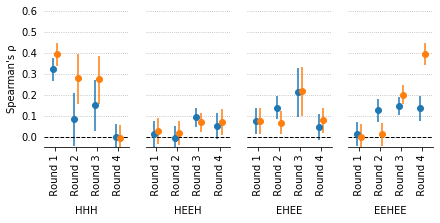

In [56]:
fig, axs = plt.subplots(1, 4, figsize=(6, 3))

for i, (domain, gp) in enumerate(sorted(correlations_df.groupby("domain"), key=lambda x: x[0], reverse=True)):
    ax = axs[i]

    gp = gp.sort_values(["domain", "library"])

    x = np.arange(4)  # the label locations
    width = 0.2  # the width of the bars

    df = gp[gp["feature"] == "network_score"]
    rects1 = ax.errorbar(
        x - width / 2,
        df["corr"].values,
        fmt="o",
        #         width,
        yerr=df[["corr_conf_lower", "corr_conf_upper"]].values.T,
        label="ProteinSolver",
    )

    df = gp[gp["feature"] == "betanov15_score"]
    rects2 = ax.errorbar(
        x + width / 2,
        -df["corr"].values,
        fmt="o",
        #         width,
        yerr=-df[["corr_conf_lower", "corr_conf_upper"]].values.T,
        label="Rosetta beta_nov",
    )

    ax.set_ylim(-0.05, 0.6)

    ax.set_xticks(x)
    ax.set_xticklabels(["{:>9s}".format(f"Round {i}") for i in range(1, 5)], rotation="vertical")
    ax.set_xlabel(domain)
    ax.set_xlim(x[0] - 0.5, x[-1] + 0.5)
    ax.hlines(0, x[0] - 0.5, x[-1] + 0.5, linestyles="--", linewidth=1)

    if i == 0:
        ax.set_ylabel("Spearman's ρ")

    ax.set_yticks([i / 10 for i in range(0, 7)])
    if i > 0:
        ax.set_yticklabels("")

    for tic in ax.yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.grid(axis="y", linestyle=":")
    
fig.subplots_adjust(left=0.09, bottom=0.325, top=0.955, right=0.99)
fig.savefig(NOTEBOOK_PATH.joinpath("gapf-design-correlations.pdf"))
fig.savefig(NOTEBOOK_PATH.joinpath("gapf-design-correlations.svg"))
fig.savefig(NOTEBOOK_PATH.joinpath("gapf-design-correlations.png"), dpi=300)

## 